In [2]:
import lightfm
import pandas as pd

In [12]:
items = pd.read_csv('./u.item', sep="|", header=None)
items.columns = ["movie_id", "movie_title", "release_date", "video_release_date",
              "IMDb_URL", "unknown", "Action", "Adventure","Animation",
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"]
items.movie_id -= 1
items = items.set_index('movie_id')
all_ratings = pd.read_csv('./u.data', sep="\t", header=None)
all_ratings.columns = ['user_id', 'item_id', 'rating', 'timestamp']
all_ratings.user_id = all_ratings.user_id - 1
all_ratings.item_id = all_ratings.item_id - 1
all_ratings = all_ratings.drop(['timestamp'], axis=1)

In [5]:
train = pd.read_csv('./ua.base', sep="\t", header=None)
train.columns = ['user_id', 'item_id', 'rating', 'timestamp']
train.user_id = train.user_id - 1
train.item_id = train.item_id - 1
train

,user_id,item_id,rating,timestamp
0,0,0,5,874965758
1,0,1,3,876893171
2,0,2,4,878542960
3,0,3,3,876893119
4,0,4,3,889751712
...,...,...,...,...
90565,942,1046,2,875502146
90566,942,1073,4,888640250
90567,942,1187,3,888640250
90568,942,1227,3,888640275


In [6]:
test = pd.read_csv('./ua.test', sep="\t", header=None)
test.columns = ['user_id', 'item_id', 'rating', 'timestamp']
test.user_id = test.user_id - 1
test.item_id = test.item_id - 1
test

,user_id,item_id,rating,timestamp
0,0,19,4,887431883
1,0,32,4,878542699
2,0,60,4,878542420
3,0,116,3,874965739
4,0,154,2,878542201
...,...,...,...,...
9425,942,231,4,888639867
9426,942,355,4,888639598
9427,942,569,1,888640125
9428,942,807,4,888639868


In [7]:
train = train.drop(['timestamp'], axis=1)
test = test.drop(['timestamp'], axis=1)

In [13]:
from lightfm.data import Dataset
import numpy as np
dataset = Dataset()
dataset.fit(users=np.unique(all_ratings['user_id']), items=np.unique(all_ratings['item_id']))

In [14]:
_, interactions_train = dataset.build_interactions([tuple(i) for i in train.to_numpy()])
_, interactions_test = dataset.build_interactions([tuple(i) for i in test.to_numpy()])

In [18]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import reciprocal_rank

In [22]:
components = [1, 2, 5, 50, 75, 100, 150]
train_result,test_result  = [], []
for i in components:
    model = LightFM(loss='warp', no_components=i, random_state=42)
    model.fit(interactions_train, epochs=50, num_threads=2)
    train_result.append(auc_score(model, interactions_train).mean())
    test_result.append(auc_score(model, interactions_test).mean())
print(train_result)
print(test_result)

[0.9015784, 0.92241573, 0.94026756, 0.9844653, 0.9925409, 0.99656963, 0.99928147]
[0.8767, 0.89527726, 0.90667474, 0.88874775, 0.878335, 0.86915135, 0.8596983]


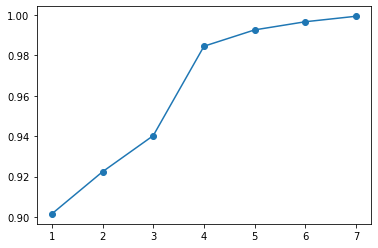

In [26]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4, 5, 6, 7], train_result, marker='o')

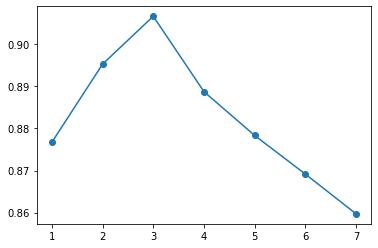

In [29]:
plt.plot([1, 2, 3, 4, 5, 6, 7], test_result, marker='o')

In [31]:
def my_prediction(mod, us_ids, it_ids):
    res = []
    for i in range(len(us_ids)):
        user_baseline = model.get_user_representations()[0][i]
        user_factors = model.get_user_representations()[1][i]
        item_baseline = model.get_item_representations()[0][i]
        item_factors = model.get_item_representations()[1][i]
        res.append((user_factors + user_baseline) * (item_baseline + item_factors)) 
    return res

In [32]:
model = LightFM(loss='warp', no_components=5, random_state=42)
model.fit(interactions_train, epochs=50, num_threads=2)
u_ids = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
i_ids = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
my_prediction(model, u_ids, i_ids)

[array([-27.873934, -25.469942, -17.688992, -16.37778 , -20.466913],
       dtype=float32),
 array([-4.111303  ,  1.5319715 , -0.38307774, -2.8991787 , -0.73404837],
       dtype=float32),
 array([-5.0035577 , -2.7078686 , -0.79530203, -2.3834884 , -3.2761798 ],
       dtype=float32),
 array([-4.8357797 ,  0.05437054, -1.44456   , -0.74709773, -0.88413876],
       dtype=float32),
 array([-5.893878 ,  1.9485235, -3.2191722, -6.937865 , -7.007372 ],
       dtype=float32),
 array([ 7.201951  , -1.5066508 , -1.5990702 ,  8.160998  ,  0.03233226],
       dtype=float32),
 array([-32.423733, -20.57108 , -19.171684, -15.343105, -32.666653],
       dtype=float32),
 array([-6.4603324, -6.584987 , -4.8702826, -2.3532405, -1.826469 ],
       dtype=float32),
 array([-4.940209 , -5.594642 , -4.4940367, -3.3971498, -3.7740119],
       dtype=float32),
 array([-2.248712 , -7.503539 , -3.6313546,  4.429342 , -5.234668 ],
       dtype=float32)]